In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [33]:
from tensorflow.keras.layers import Attention, Conv2D, Conv3D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, Resizing, MultiHeadAttention, concatenate
from tensorflow.keras.layers import BatchNormalization, LayerNormalization, ReLU, Input, GlobalAveragePooling1D, GlobalAveragePooling2D, GlobalAveragePooling3D
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, StratifiedKFold
import keras
from keras import layers
from sklearn.metrics import precision_score, recall_score

In [3]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Data download and split
### It should be run the first time to download and split data into train, validation, and test set and saving them into drive for later use


In [ ]:
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import patoolib

## Stanford 40
### Download the data
You can see the zip files if you click the Files tab (looks like a folder symbol on the left of the screen)

In [ ]:
!wget http://vision.stanford.edu/Datasets/Stanford40_JPEGImages.zip
!wget http://vision.stanford.edu/Datasets/Stanford40_ImageSplits.zip

--2024-09-02 15:01:17--  http://vision.stanford.edu/Datasets/Stanford40_JPEGImages.zip
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 304771808 (291M) [application/zip]
Saving to: ‘Stanford40_JPEGImages.zip’

Stanford40_JPEGImag 100%[===================>] 290.65M  9.55MB/s    in 20s     

2024-09-02 15:01:38 (14.4 MB/s) - ‘Stanford40_JPEGImages.zip’ saved [304771808/304771808]

--2024-09-02 15:01:38--  http://vision.stanford.edu/Datasets/Stanford40_ImageSplits.zip
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62010 (61K) [application/zip]
Saving to: ‘Stanford40_ImageSplits.zip’

Stanford40_ImageSpl 100%[===================>]  60.56K  --.-KB/s    in 0.05s   

2024-0

### Unzip it

In [ ]:
!unzip Stanford40_JPEGImages.zip -d Stanford40/
!unzip Stanford40_ImageSplits.zip -d Stanford40/

Streaming output truncated to the last 5000 lines.
  inflating: Stanford40/JPEGImages/phoning_213.jpg  
  inflating: Stanford40/JPEGImages/phoning_214.jpg  
  inflating: Stanford40/JPEGImages/phoning_215.jpg  
  inflating: Stanford40/JPEGImages/phoning_216.jpg  
  inflating: Stanford40/JPEGImages/phoning_217.jpg  
  inflating: Stanford40/JPEGImages/phoning_218.jpg  
  inflating: Stanford40/JPEGImages/phoning_219.jpg  
  inflating: Stanford40/JPEGImages/phoning_220.jpg  
  inflating: Stanford40/JPEGImages/phoning_221.jpg  
  inflating: Stanford40/JPEGImages/phoning_222.jpg  
  inflating: Stanford40/JPEGImages/phoning_223.jpg  
  inflating: Stanford40/JPEGImages/phoning_224.jpg  
  inflating: Stanford40/JPEGImages/phoning_225.jpg  
  inflating: Stanford40/JPEGImages/phoning_226.jpg  
  inflating: Stanford40/JPEGImages/phoning_227.jpg  
  inflating: Stanford40/JPEGImages/phoning_228.jpg  
  inflating: Stanford40/JPEGImages/phoning_229.jpg  
  inflating: Stanford40/JPEGImages/phoning_230.j

### Read the train and test splits, combine them and make better splits to help training networks easier.

In [ ]:
from collections import Counter
from sklearn.model_selection import train_test_split

keep_stanford40 = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse",
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]
with open(r'Stanford40/ImageSplits/train.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    train_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]

with open(r'Stanford40/ImageSplits/test.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    test_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]

# Combine the splits and split for keeping more images in the training set than the test set.
all_files = train_files + test_files
all_labels = train_labels + test_labels
train_files, test_files = train_test_split(all_files, test_size=0.1, random_state=0, stratify=all_labels)
train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]
test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]
print(f'Train files ({len(train_files)}):\n\t')
print(f'Train labels ({len(train_labels)}):\n\t\n'\
      f'Train Distribution:{list(Counter(sorted(train_labels)).items())}\n')
print(f'Test files ({len(test_files)}):\n\t')
print(f'Test labels ({len(test_labels)}):\n\t\n'\
      f'Test Distribution:{list(Counter(sorted(test_labels)).items())}\n')
action_categories = sorted(list(set(train_labels)))
print(f'Action categories ({len(action_categories)}):\n{action_categories}')

Train files (2733):
	
Train labels (2733):
	
Train Distribution:[('applauding', 256), ('climbing', 265), ('drinking', 230), ('jumping', 265), ('pouring_liquid', 180), ('riding_a_bike', 264), ('riding_a_horse', 266), ('running', 226), ('shooting_an_arrow', 193), ('smoking', 217), ('throwing_frisby', 182), ('waving_hands', 189)]

Test files (304):
	
Test labels (304):
	
Test Distribution:[('applauding', 28), ('climbing', 30), ('drinking', 26), ('jumping', 30), ('pouring_liquid', 20), ('riding_a_bike', 29), ('riding_a_horse', 30), ('running', 25), ('shooting_an_arrow', 21), ('smoking', 24), ('throwing_frisby', 20), ('waving_hands', 21)]

Action categories (12):
['applauding', 'climbing', 'drinking', 'jumping', 'pouring_liquid', 'riding_a_bike', 'riding_a_horse', 'running', 'shooting_an_arrow', 'smoking', 'throwing_frisby', 'waving_hands']


### Visualize some photos from the training files and also print their labels


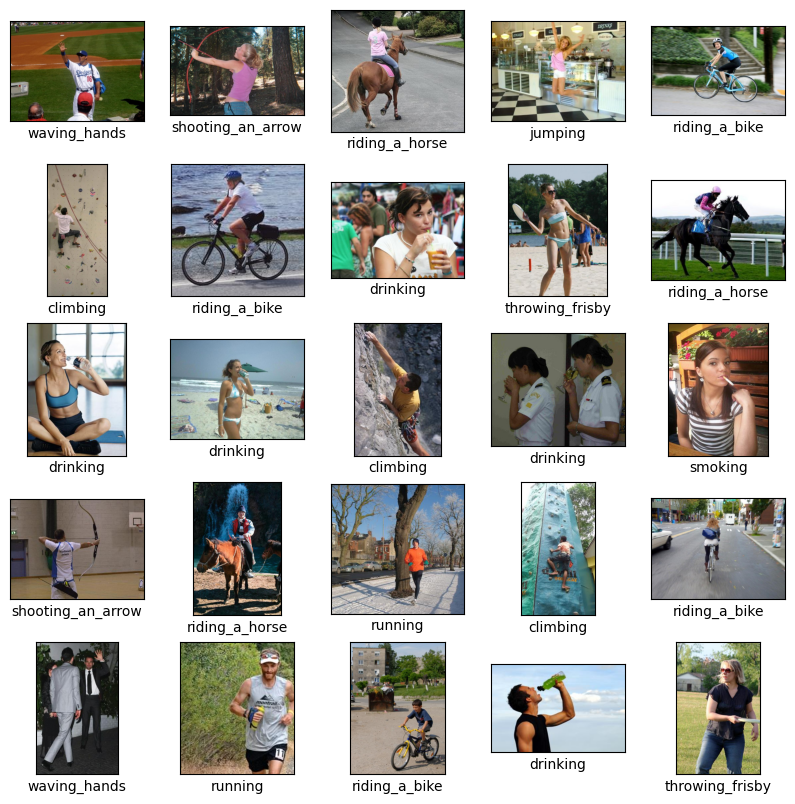

In [ ]:
import matplotlib.pyplot as plt
import random
import cv2

plt.figure(figsize=(10,10))
for i in range(25):
    image_no = random.randrange(0,1000)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = cv2.imread(f'Stanford40/JPEGImages/{train_files[image_no]}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(train_labels[image_no])
plt.show()

In [ ]:
import os
stanford_train_data = []
stanford_test_data = []
stanford_val_data = []

# Create the parent directories first
if not os.path.exists(os.path.join("Stanford40","train")):
    os.mkdir (os.path.join("Stanford40","train"))
if not os.path.exists(os.path.join("Stanford40","validation")):
    os.mkdir (os.path.join("Stanford40","validation"))
if not os.path.exists(os.path.join("Stanford40","test")):
    os.mkdir (os.path.join("Stanford40","test"))

train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=0, stratify=train_labels)
train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]
val_labels = ['_'.join(name.split('_')[:-1]) for name in val_files]

for i in train_files:
    img = cv2.imread(f'Stanford40/JPEGImages/{i}')
    category_name = '_'.join(i.split('_')[:-1])
    if not os.path.exists(os.path.join("Stanford40","train",category_name)):
        os.mkdir (os.path.join("Stanford40","train",category_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (256,256))
    # img = img / 255.0
    cv2.imwrite(os.path.join("Stanford40","train",category_name,i), img)
    stanford_train_data.append(img)

for i in val_files:
    img = cv2.imread(f'Stanford40/JPEGImages/{i}')
    category_name = '_'.join(i.split('_')[:-1])
    if not os.path.exists(os.path.join("Stanford40","validation",category_name)):
        os.mkdir (os.path.join("Stanford40","validation",category_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (256,256))
    # img = img / 255.0
    cv2.imwrite(os.path.join("Stanford40","validation",category_name,i), img)
    stanford_val_data.append(img)

for i in test_files:
    img = cv2.imread(f'Stanford40/JPEGImages/{i}')
    category_name = '_'.join(i.split('_')[:-1])
    if not os.path.exists(os.path.join("Stanford40","test",category_name)):
        os.mkdir (os.path.join("Stanford40","test",category_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (256,256))
    # img = img / 255.0
    cv2.imwrite(os.path.join("Stanford40","test",category_name,i), img)
    stanford_test_data.append(img)

###Saving the processed dataset in the drive for later use

In [ ]:
!mkdir /content/drive/MyDrive/Action_recognition/
!mkdir /content/drive/MyDrive/Action_recognition/Stanford40
!zip -r train.zip Stanford40/train/
!zip -r validation.zip Stanford40/validation/
!zip -r test.zip Stanford40/test/
!cp -r train.zip /content/drive/MyDrive/Action_recognition/Stanford40/
!cp -r test.zip /content/drive/MyDrive/Action_recognition/Stanford40/
!cp -r validation.zip /content/drive/MyDrive/Action_recognition/Stanford40/

  adding: Stanford40/train/ (stored 0%)
  adding: Stanford40/train/waving_hands/ (stored 0%)
  adding: Stanford40/train/waving_hands/waving_hands_077.jpg (deflated 0%)
  adding: Stanford40/train/waving_hands/waving_hands_047.jpg (deflated 0%)
  adding: Stanford40/train/waving_hands/waving_hands_173.jpg (deflated 0%)
  adding: Stanford40/train/waving_hands/waving_hands_161.jpg (deflated 0%)
  adding: Stanford40/train/waving_hands/waving_hands_054.jpg (deflated 0%)
  adding: Stanford40/train/waving_hands/waving_hands_093.jpg (deflated 0%)
  adding: Stanford40/train/waving_hands/waving_hands_209.jpg (stored 0%)
  adding: Stanford40/train/waving_hands/waving_hands_180.jpg (deflated 0%)
  adding: Stanford40/train/waving_hands/waving_hands_004.jpg (deflated 0%)
  adding: Stanford40/train/waving_hands/waving_hands_010.jpg (deflated 0%)
  adding: Stanford40/train/waving_hands/waving_hands_081.jpg (deflated 0%)
  adding: Stanford40/train/waving_hands/waving_hands_156.jpg (stored 0%)
  adding: S

## Human Motion Database 51 (HMDB51)
### Download the dataset

In [ ]:
# Download HMDB51 data and splits from serre lab website
!wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
!wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar

--2024-09-08 14:55:20--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar
Resolving serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)... 128.148.254.114
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar [following]
--2024-09-08 14:55:20--  https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 199521 (195K)
Saving to: ‘test_train_splits.rar’

test_train_splits.r 100%[===================>] 194.84K   685KB/s    in 0.3s    

2024-09-08 14:55:20 (685 KB/s) - ‘test_train_splits.rar’ saved [199521/199521]



### Extract and organize the data.

In [ ]:
! mkdir video_data
! mkdir test_train_splits
patoolib.extract_archive("test_train_splits.rar", outdir="test_train_splits")
! rm test_train_splits.rar
patoolib.extract_archive("hmdb51_org.rar", outdir="hmdb51_org")
! rm hmdb51_org.rar
import os
keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse",
        "run", "shoot_bow", "smoke", "throw", "wave"]
for files in os.listdir(r'./hmdb51_org'):
    foldername = files.split('.')[0]
    if foldername in keep_hmdb51:
    # extract only the relevant classes for the assignment.
        os.system("mkdir -p video_data/" + foldername)
        patoolib.extract_archive("hmdb51_org/"+ files , outdir = "video_data")
!rm -rf hmdb51_org

mkdir: cannot create directory ‘video_data’: File exists
mkdir: cannot create directory ‘test_train_splits’: File exists


INFO patool: Extracting test_train_splits.rar ...
INFO:patool:Extracting test_train_splits.rar ...
INFO patool: running /usr/bin/unrar x -- /content/test_train_splits.rar
INFO:patool:running /usr/bin/unrar x -- /content/test_train_splits.rar
INFO patool:     with cwd='test_train_splits', input=''
INFO:patool:    with cwd='test_train_splits', input=''
INFO patool: ... test_train_splits.rar extracted to `test_train_splits'.
INFO:patool:... test_train_splits.rar extracted to `test_train_splits'.


### Split the dataset into train and test

In [ ]:
keep_stanford40 = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse",
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]
keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse",
        "run", "shoot_bow", "smoke", "throw", "wave"]

In [ ]:
import glob
from collections import Counter
import os

keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse",
        "run", "shoot_bow", "smoke", "throw", "wave"]
TRAIN_TAG, TEST_TAG = 1, 2
train_files, test_files = [], []
train_labels, test_labels = [], []
split_pattern_name = f"*test_split1.txt"
split_pattern_path = os.path.abspath( os.path.join(os.path.curdir,r'test_train_splits','testTrainMulti_7030_splits', split_pattern_name))
annotation_paths = glob.glob(split_pattern_path)
print(f'Found {len(annotation_paths)} annotation files.')
for filepath in annotation_paths:
    class_name = '_'.join(filepath.split('/')[-1].split('_')[:-2])
    if class_name not in keep_hmdb51:
        continue  # skipping the classes that we won't use.

    with open(filepath) as fid:
        lines = fid.readlines()
    for line in lines:
        video_filename, tag_string = line.split()
        tag = int(tag_string)
        if tag == TRAIN_TAG:
            train_files.append(video_filename)
            train_labels.append(class_name)
        elif tag == TEST_TAG:
            test_files.append(video_filename)
            test_labels.append(class_name)

print(f'Train files ({len(train_files)}):\n\t')
print(f'Train labels ({len(train_labels)}):\n\t\n'\
      f'Train Distribution:{list(Counter(sorted(train_labels)).items())}\n')
print(f'Test files ({len(test_files)}):\n\t')
print(f'Test labels ({len(test_labels)}):\n\t\n'\
      f'Test Distribution:{list(Counter(sorted(test_labels)).items())}\n')
action_categories = sorted(list(set(train_labels)))
print(f'Action categories ({len(action_categories)}):\n{action_categories}')

Found 51 annotation files.
Train files (840):
	
Train labels (840):
	
Train Distribution:[('clap', 70), ('climb', 70), ('drink', 70), ('jump', 70), ('pour', 70), ('ride_bike', 70), ('ride_horse', 70), ('run', 70), ('shoot_bow', 70), ('smoke', 70), ('throw', 70), ('wave', 70)]

Test files (360):
	
Test labels (360):
	
Test Distribution:[('clap', 30), ('climb', 30), ('drink', 30), ('jump', 30), ('pour', 30), ('ride_bike', 30), ('ride_horse', 30), ('run', 30), ('shoot_bow', 30), ('smoke', 30), ('throw', 30), ('wave', 30)]

Action categories (12):
['clap', 'climb', 'drink', 'jump', 'pour', 'ride_bike', 'ride_horse', 'run', 'shoot_bow', 'smoke', 'throw', 'wave']


### Copy train and test videoes to their directory

In [ ]:
import os
import shutil

!rm -rf Hmdb51
!mkdir Hmdb51
os.mkdir (os.path.join("Hmdb51","train_videos"))
os.mkdir (os.path.join("Hmdb51","test_videos"))

for i in range(len(train_files)):
    category_name = keep_stanford40[keep_hmdb51.index(train_labels[i])]
    vPath = os.path.join("video_data",train_labels[i],train_files[i])
    dPath = os.path.join("Hmdb51","train_videos",category_name)
    if not os.path.exists(dPath):
        os.mkdir (dPath)
    shutil.copy(vPath, dPath)

for i in range(len(test_files)):
    category_name = keep_stanford40[keep_hmdb51.index(test_labels[i])]
    vPath = os.path.join("video_data",test_labels[i],test_files[i])
    dPath = os.path.join("Hmdb51","test_videos",category_name)
    if not os.path.exists(dPath):
        os.mkdir (dPath)
    shutil.copy(vPath, dPath)

!rm -rf video_data

### Extract the middle frame of each video and save them to their related directory

In [ ]:
import os
import shutil
import cv2

if not os.path.exists(os.path.join("Hmdb51","train_frames")):
  os.mkdir (os.path.join("Hmdb51","train_frames"))
if not os.path.exists(os.path.join("Hmdb51","test_frames")):
  os.mkdir (os.path.join("Hmdb51","test_frames"))

for i in range(len(train_files)):
    category_name = keep_stanford40[keep_hmdb51.index(train_labels[i])]
    vPath = os.path.join("Hmdb51", "train_videos", category_name, train_files[i])
    dPath = os.path.join("Hmdb51","train_frames", category_name)
    if not os.path.exists(dPath):
        os.mkdir (dPath)
    # Load the video for which the background needs to be substracted
    camera_handle = cv2.VideoCapture(vPath)
    # Reset frame number to middle
    num_frames = int(camera_handle.get(cv2.CAP_PROP_FRAME_COUNT))
    camera_handle.set(cv2.CAP_PROP_POS_FRAMES, int(num_frames/2))

    ret, frame = camera_handle.read()
    fileName = train_files[i].split('.')[0]+".jpg"
    cv2.imwrite(os.path.join(dPath,fileName), frame)

for i in range(len(test_files)):
    category_name = keep_stanford40[keep_hmdb51.index(test_labels[i])]
    vPath = os.path.join("Hmdb51", "test_videos", category_name, test_files[i])
    dPath = os.path.join("Hmdb51", "test_frames", category_name)
    if not os.path.exists(dPath):
        os.mkdir (dPath)
    # Load the video for which the background needs to be substracted
    camera_handle = cv2.VideoCapture(vPath)
    # Reset frame number to middle
    num_frames = int(camera_handle.get(cv2.CAP_PROP_FRAME_COUNT))
    camera_handle.set(cv2.CAP_PROP_POS_FRAMES, int(num_frames/2))

    ret, frame = camera_handle.read()
    fileName = test_files[i].split('.')[0]+".jpg"
    cv2.imwrite(os.path.join(dPath,fileName), frame)


### Calculate the optical flows

In [ ]:
import cv2 as cv
import numpy as np
import os

def save_optical_flow(inputVideo, outputPath):
    cap = cv.VideoCapture(inputVideo)
    num_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

    # Set the starting frame to capture from the middle of the video
    # cap.set(cv.CAP_PROP_POS_FRAMES, int((num_frames-16)/2))
    stride = num_frames // 16

    ret, frame1 = cap.read()
    prvs = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255  # Set the saturation to maximum

    # Initialize DISOpticalFlow
    dis_flow = cv.DISOpticalFlow_create(cv.DISOPTICAL_FLOW_PRESET_MEDIUM)

    counter = 0
    while True:
        cap.set(cv.CAP_PROP_POS_FRAMES, counter * stride)
        ret, frame2 = cap.read()
        if not ret or counter > 15:
            # print('No frames grabbed or frame limit reached!')
            break

        next = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)

        # Calculate dense optical flow using the DIS algorithm
        flow = dis_flow.calc(prvs, next, None)

        # Convert flow to polar coordinates (magnitude and angle)
        mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])

        # Update the HSV image for visualizing flow
        hsv[..., 0] = ang * 180 / np.pi / 2  # Hue corresponds to the direction of the flow
        hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)  # Value corresponds to magnitude

        # Convert HSV to BGR (for visualization or saving as color image)
        bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

        # Optionally, convert BGR to grayscale to match your original output
        # gry = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)

        # Resize the grayscale image to 256x256 (optional)
        # gry = cv.resize(gry, (256, 256), interpolation=cv.INTER_AREA)
        gry = cv.resize(bgr, (256, 256), interpolation=cv.INTER_AREA)

        # Save the resulting grayscale image
        cv.imwrite(os.path.join(outputPath, str(counter) + ".jpg"), gry)

        # Update the previous frame for the next iteration
        prvs = next
        counter += 1


In [ ]:
import numpy as np
import cv2 as cv
import os

def save_optical_flow(inputVideo, outputPath):
    cap = cv.VideoCapture(inputVideo)
    num_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    cap.set(cv.CAP_PROP_POS_FRAMES, int((num_frames-16)/2))
    ret, frame1 = cap.read()
    prvs = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255
    counter = 0
    while(1):
        ret, frame2 = cap.read()
        if not ret or counter > 15:
#             print('No frames grabbed!')
            break
        next = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
        flow = cv.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
        hsv[..., 0] = ang*180/np.pi/2
        hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
        bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
        gry = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)
#         cv.imshow('frame2', bgr)
#         k = cv.waitKey(30) & 0xff
#         if k == 27:
#             break
#         elif k == ord('s'):
#             cv.imwrite('opticalfb.png', frame2)
#             cv.imwrite('opticalhsv.png', bgr)
        prvs = next
        gry = cv.resize(gry, (256,256), interpolation = cv.INTER_AREA)
        cv.imwrite(os.path.join(outputPath,str(counter)+".jpg"), gry)
        counter += 1

In [ ]:
!rm -rf Hmdb51/train_optical_flow
!rm -rf Hmdb51/test_optical_flow

In [ ]:
train_dir = os.path.join("Hmdb51","train_optical_flow_DIS_BGR")
test_dir = os.path.join("Hmdb51","test_optical_flow_DIS_BGR")

if not os.path.exists(train_dir):
  os.mkdir (train_dir)
if not os.path.exists(test_dir):
  os.mkdir (test_dir)

for i in range(len(train_files)):
  category_name = keep_stanford40[keep_hmdb51.index(train_labels[i])]
  vPath = os.path.join("Hmdb51", "train_videos", category_name, train_files[i])
  dPath = os.path.join(train_dir, category_name)
  if not os.path.exists(dPath):
      os.mkdir (dPath)
  dPath = os.path.join(os.path.join(dPath,train_files[i].split('.')[0]))
  if not os.path.exists(dPath):
      os.mkdir(dPath)
  save_optical_flow(vPath, dPath)

for i in range(len(test_files)):
  category_name = keep_stanford40[keep_hmdb51.index(test_labels[i])]
  vPath = os.path.join("Hmdb51", "test_videos", category_name, test_files[i])
  dPath = os.path.join(test_dir, category_name)
  if not os.path.exists(dPath):
      os.mkdir (dPath)
  dPath = os.path.join(os.path.join(dPath,test_files[i].split('.')[0]))
  if not os.path.exists(dPath):
      os.mkdir(dPath)
  save_optical_flow(vPath, dPath)


In [ ]:
!mkdir /content/drive/MyDrive/Action_recognition/Hmdb51
!zip -r Hmdb51_DIS_BGR.zip Hmdb51
!cp -r Hmdb51_DIS_BGR.zip /content/drive/MyDrive/Action_recognition/Hmdb51/

Streaming output truncated to the last 5000 lines.
  adding: Hmdb51/train_optical_flow/drinking/GoneBabyGone_drink_h_cm_np1_fr_goo_1/0.jpg (deflated 0%)
  adding: Hmdb51/train_optical_flow/drinking/GoneBabyGone_drink_h_cm_np1_fr_goo_1/2.jpg (deflated 0%)
  adding: Hmdb51/train_optical_flow/drinking/GoneBabyGone_drink_h_cm_np1_fr_goo_1/1.jpg (deflated 0%)
  adding: Hmdb51/train_optical_flow/drinking/GoneBabyGone_drink_h_cm_np1_fr_goo_1/11.jpg (deflated 0%)
  adding: Hmdb51/train_optical_flow/drinking/GoneBabyGone_drink_h_cm_np1_fr_goo_1/14.jpg (stored 0%)
  adding: Hmdb51/train_optical_flow/drinking/GoneBabyGone_drink_h_cm_np1_fr_goo_1/12.jpg (stored 0%)
  adding: Hmdb51/train_optical_flow/drinking/GoneBabyGone_drink_h_cm_np1_fr_goo_1/3.jpg (deflated 1%)
  adding: Hmdb51/train_optical_flow/drinking/GoneBabyGone_drink_h_cm_np1_fr_goo_1/7.jpg (stored 0%)
  adding: Hmdb51/train_optical_flow/drinking/GoneBabyGone_drink_h_cm_np1_fr_goo_1/10.jpg (stored 0%)
  adding: Hmdb51/train_optical_flow

# Load data

## Copy data from the drive

### It can be used on the second run for loading the processed data from the drive


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!cp /content/drive/MyDrive/Projects/Action_recognition/Hmdb51/Hmdb51_DIS_BGR.zip .
!unzip Hmdb51_DIS_BGR.zip
!rm Hmdb51_DIS_BGR.zip
!cp -r /content/drive/MyDrive/Projects/Action_recognition/Stanford40 .
!unzip Stanford40/train.zip
!unzip Stanford40/validation.zip
!unzip Stanford40/test.zip
!rm Stanford40/train.zip
!rm Stanford40/validation.zip
!rm Stanford40/test.zip

Streaming output truncated to the last 5000 lines.
 extracting: Hmdb51/train_optical_flow/applauding/Flamenco_Dance_Steps_-_Flamenco_Dance_Soft_Claps_clap_u_cm_np1_fr_goo_2/13.jpg  
  inflating: Hmdb51/train_optical_flow/applauding/Flamenco_Dance_Steps_-_Flamenco_Dance_Soft_Claps_clap_u_cm_np1_fr_goo_2/0.jpg  
  inflating: Hmdb51/train_optical_flow/applauding/Flamenco_Dance_Steps_-_Flamenco_Dance_Soft_Claps_clap_u_cm_np1_fr_goo_2/2.jpg  
  inflating: Hmdb51/train_optical_flow/applauding/Flamenco_Dance_Steps_-_Flamenco_Dance_Soft_Claps_clap_u_cm_np1_fr_goo_2/1.jpg  
  inflating: Hmdb51/train_optical_flow/applauding/Flamenco_Dance_Steps_-_Flamenco_Dance_Soft_Claps_clap_u_cm_np1_fr_goo_2/11.jpg  
  inflating: Hmdb51/train_optical_flow/applauding/Flamenco_Dance_Steps_-_Flamenco_Dance_Soft_Claps_clap_u_cm_np1_fr_goo_2/14.jpg  
  inflating: Hmdb51/train_optical_flow/applauding/Flamenco_Dance_Steps_-_Flamenco_Dance_Soft_Claps_clap_u_cm_np1_fr_goo_2/12.jpg  
  inflating: Hmdb51/train_optical_f

## Load Stanford dataset

### Data loader

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.5,1.5],
        shear_range=0.2,
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [9]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
image_size = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32
stanford_train_data = train_datagen.flow_from_directory(
    "Stanford40/train",
    target_size = image_size,
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle = True
    )

stanford_validation_data = val_datagen.flow_from_directory(
    "Stanford40/validation",
    target_size = image_size,
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle = True
    )

stanford_test_data = test_datagen.flow_from_directory(
    "Stanford40/test",
    target_size = image_size,
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle = False
    )

Found 2459 images belonging to 12 classes.
Found 274 images belonging to 12 classes.
Found 304 images belonging to 12 classes.


In [10]:
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np

keep_stanford40 = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse",
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]
data, labels = next(iter(stanford_train_data))
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = data[i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(keep_stanford40[ np.argmax(labels[i])])
plt.show()

## Load Hmdb51 dataset

### Load frame data for model1

In [10]:
train_datagen_hmdb = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[1,2],
        shear_range=0.2,
        validation_split=0.2,

)
val_datagen_hmdb = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[1,2],
        shear_range=0.2,
        validation_split=0.2,

)
test_datagen_hmdb = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [39]:
seed_train_validation = 1 # Must be same for train_ds and val_ds
shuffle_value = True
validation_split = 0.1
IMG_WIDTH = 256
IMG_HEIGHT = 256
image_size = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32

hmdb_train_data = train_datagen_hmdb.flow_from_directory(
    "Hmdb51/train_frames",
    target_size = image_size,
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle = True,
    subset = "training",
    seed = seed_train_validation
)

hmdb_val_data = train_datagen_hmdb.flow_from_directory(
    "Hmdb51/train_frames",
    target_size = image_size,
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle = True,
    subset = "validation",
    seed = seed_train_validation
)

hmdb_test_data = test_datagen_hmdb.flow_from_directory(
    "Hmdb51/test_frames",
    target_size = image_size,
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle = False
    )

Found 672 images belonging to 12 classes.
Found 168 images belonging to 12 classes.
Found 360 images belonging to 12 classes.


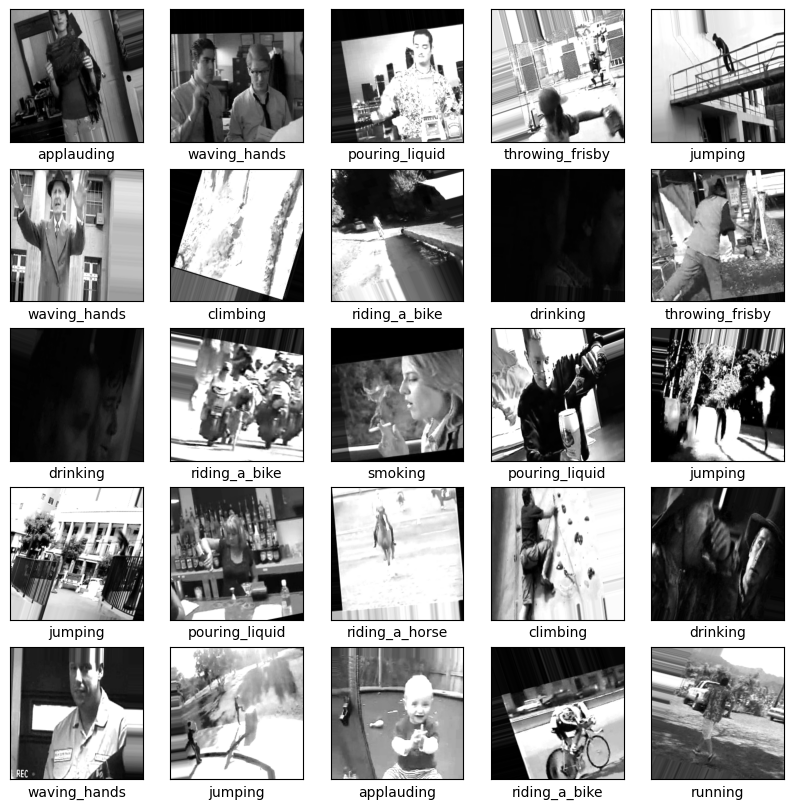

In [44]:
import matplotlib.pyplot as plt
import random
import cv2
keep_stanford40 = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse",
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]
data, labels = next(iter(hmdb_val_data))
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = data[i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(keep_stanford40[ np.argmax(labels[i])])
plt.show()

### Load optical flow data for model2

In [13]:
import os
import cv2
import numpy as np

IMG_WIDTH = 128
IMG_HEIGHT = 128
keep_stanford40 = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse",
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]

def load_optical_flow(dirname):
    optical_flows, labels = [], []
    for category in os.listdir(dirname):
        category_path = os.path.join(dirname,category)
        for sample in os.listdir(category_path):
            frames = []
            sample_path = os.path.join(category_path, sample)
            for frame in os.listdir(sample_path):
                img = cv2.imread(os.path.join(sample_path, frame))
                img = cv2.resize(img,(IMG_WIDTH, IMG_HEIGHT))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img / 255.0
                frames.append(img)
            optical_flows.append(frames)
            labels.append(keep_stanford40.index(category))
    optical_flows = np.array(optical_flows)
    labels = np.array(labels)
    return optical_flows, labels

In [14]:
optical_flow_train_data, optical_flow_train_labels = load_optical_flow("Hmdb51/train_optical_flow_DIS_BGR")
optical_flow_train_labels = optical_flow_train_labels.reshape(-1,1)

In [15]:
optical_flow_test_data, optical_flow_test_labels = load_optical_flow("Hmdb51/test_optical_flow_DIS_BGR")
optical_flow_test_labels = optical_flow_test_labels.reshape(-1,1)

In [16]:
optical_flow_train_data.shape, optical_flow_train_labels.shape

((840, 16, 128, 128), (840, 1))

In [17]:
optical_flow_test_data.shape, optical_flow_test_labels.shape

((360, 16, 128, 128), (360, 1))

### Load frame and optical flow data for model3

In [89]:
def get_data_generator(x1, x2, y, batch_size=32):
    # Define the data generator for the two input streams
    def data_generator():
        while True:
            indices = np.random.permutation(len(y))
            for i in range(0, len(indices), batch_size):
                batch_indices = indices[i:i+batch_size]
                batch_x1 = x1[batch_indices]
                batch_x2 = x2[batch_indices]
                batch_y = y[batch_indices]
                yield ({"input_1":batch_x1, "input_2":batch_x2}, batch_y)

    # Create the data generator and return it
    return data_generator()

In [90]:
import os
import cv2
import numpy as np

IMG_WIDTH = 256
IMG_HEIGHT = 256
keep_stanford40 = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse",
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]

def load_hmdb(dirname):
    data, labels = [], []
    for category in os.listdir(dirname):
        category_path = os.path.join(dirname,category)
        for sample in os.listdir(category_path):
            img = cv2.imread(os.path.join(category_path, sample))
            img = cv2.resize(img,(IMG_WIDTH, IMG_HEIGHT))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = img / 255.0
            data.append(img)
            labels.append(keep_stanford40.index(category))
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [91]:
hmdb_train_data, hmdb_train_labels = load_hmdb("Hmdb51/train_frames")
hmdb_train_labels = hmdb_train_labels.reshape(-1,1)

In [92]:
hmdb_test_data, hmdb_test_labels = load_hmdb("Hmdb51/test_frames")
hmdb_test_labels = hmdb_test_labels.reshape(-1,1)

In [93]:
hmdb_train_data.shape, hmdb_train_labels.shape

((840, 256, 256), (840, 1))

In [94]:
hmdb_test_data.shape, hmdb_test_labels.shape

((360, 256, 256), (360, 1))

## Copy models from the drive

In [52]:
!cp -r /content/drive/MyDrive/Projects/Action_recognition/Stanford40.keras .
!cp -r /content/drive/MyDrive/Projects/Action_recognition/Hmdb51.keras .
!cp -r /content/drive/MyDrive/Projects/Action_recognition/final_model_optical_flow.keras .

# Train model1 on the Stanford dataset


## Model1 definition

In [24]:
# Define input shapes
input_shape1 = (256, 256, 1)

# Define the first input stream
input1 = tf.keras.Input(shape=input_shape1, name='input_1')

x1 = Conv2D(32, (3, 3), activation='relu')(input1)
x1 = Conv2D(32, (3, 3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Conv2D(128, (3, 3), activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Conv2D(256, (3, 3), activation='relu')(x1)
x1 = Reshape((-1, 256))(x1)
# x1 = Attention()([x1, x1])
x1 = Reshape((60, 60, 256))(x1)
x1 = MaxPooling2D((3, 3))(x1)
x1 = Conv2D(128, (3, 3), activation='relu')(x1)
x1 = MaxPooling2D((3, 3))(x1)
x1 = Conv2D(64, (3, 3), activation='relu')(x1)
x1 = Dropout(0.5)(x1)
x1 = Reshape((-1, 64))(x1)
x1 = Attention(dropout = 0.3)([x1, x1])
x1 = Flatten()(x1)
x1 = Dense(512, activation='relu')(x1)
x1 = Dense(128, activation='relu')(x1)
output = Dense(12)(x1)

# Create the model
model1 = tf.keras.models.Model(inputs=input1, outputs=output)

# Print model summary
model1.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)      │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 254, 254, 32)   │            320 │ input_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 252, 252, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 252, 252, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 126, 126, 32)   │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 124, 124, 128)  │         36,992 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 62, 62, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 60, 60, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 3600, 256)      │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 60, 60, 256)    │              0 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 20, 20, 256)    │              0 │ reshape_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 18, 18, 128)    │        295,040 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 6, 6, 128)      │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 4, 4, 64)       │         73,792 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 4, 4, 64)       │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 16, 64)         │              0 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 16, 64)         │              0 │ reshape_2[0][0],       │
│                      

 Total params: 1,302,700 (4.97 MB)

 Trainable params: 1,302,636 (4.97 MB)

 Non-trainable params: 64 (256.00 B)

In [29]:
model1.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

## Model1 training

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True)

history = model1.fit(stanford_train_data, epochs=500, validation_data = stanford_validation_data, callbacks=[early_stop])

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs, loss, 'r', label='Training Loss')
ax1.plot(epochs, val_loss, 'b', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.legend(loc=0)

ax2.plot(epochs, acc, 'r', label='Training Accuracy')
ax2.plot(epochs, val_acc, 'b', label='Validation Accuracy')
ax2.set_title('Training and validation accuracy')
ax2.legend(loc=0)

plt.tight_layout()
plt.show()

In [ ]:
model1.save("Stanford40.keras")

## Model1 evaluation on the Stanford dataset

In [ ]:
model1.evaluate(stanford_test_data)

In [ ]:
# Assuming you have already trained your model 'model1' and have test data 'stanford_test_data'

# 1. Get True Labels and Predictions
y_true = stanford_test_data.classes
y_pred = model1.predict(stanford_test_data)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

# 2. Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Get Class Labels (if available)
class_names = stanford_test_data.class_indices  # Get class names from the generator

# 4. Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)  # Add labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Model1')
plt.show()

## Evaluate model1 on the hmdb51 dataset

### Load model1 from the checkpoint

In [ ]:
model1 = tf.keras.models.load_model("Stanford40.keras")

### Evaluate model1 on the hmdb51 dataset

In [ ]:
model1.evaluate(hmdb_val_data)

In [ ]:

# Assuming you have already trained your model 'model1' and have test data 'stanford_test_data'

# 1. Get True Labels and Predictions
y_true = hmdb_val_data.classes
y_pred = model1.predict(hmdb_val_data)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

# 2. Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Get Class Labels (if available)
class_names = hmdb_val_data.class_indices  # Get class names from the generator

# 4. Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)  # Add labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Model1')
plt.show()

# Fine tune model1 on the sample frames of the Hmdb51 dataset

## Fine-tuning

In [ ]:
model1.layers

[<InputLayer name=input_1, built=True>,
 <Conv2D name=conv2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_3, built=True>,
 <Reshape name=reshape, built=True>,
 <Reshape name=reshape_1, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Conv2D name=conv2d_4, built=True>,
 <MaxPooling2D name=max_pooling2d_3, built=True>,
 <Conv2D name=conv2d_5, built=True>,
 <Dropout name=dropout, built=True>,
 <Reshape name=reshape_2, built=True>,
 <Attention name=attention, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [ ]:
number_of_freezed_layers = 10

for i in range(number_of_freezed_layers):
    model1.layers[i].trainable = False

In [ ]:
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 254, 254,  │        320 │ input_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 252, 252,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 252, 252,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 126, 126,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 124, 124,  │     36,992 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 62, 62,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 60, 60,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 3600, 256) │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 60, 60,    │          0 │ reshape[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 20, 20,    │          0 │ reshape_1[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 18, 18,    │    295,040 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 128) │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 64)  │     73,792 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4, 4, 64)  │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 16, 64)    │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 16, 64)    │          0 │ reshape_2[0][0],  │
│ (Attention)         │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,907,974 (14.91 MB)

 Trainable params: 960,844 (3.67 MB)

 Non-trainable params: 341,856 (1.30 MB)

 Optimizer params: 2,605,274 (9.94 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True)

history = model1.fit(hmdb_train_data, epochs=500, validation_data=hmdb_val_data, callbacks=[early_stop])

Epoch 1/500


/home/sohiyel/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.2351 - loss: 2.5506 - val_accuracy: 0.2500 - val_loss: 2.1731
Epoch 2/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.3052 - loss: 2.0174 - val_accuracy: 0.2917 - val_loss: 2.0348
Epoch 3/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.3104 - loss: 1.9921 - val_accuracy: 0.3333 - val_loss: 1.9726
Epoch 4/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.3483 - loss: 1.9047 - val_accuracy: 0.3631 - val_loss: 1.8928
Epoch 5/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.3683 - loss: 1.8796 - val_accuracy: 0.3274 - val_loss: 1.9764
Epoch 6/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.3892 - loss: 1.8569 - val_accuracy: 0.3155 - val_loss: 1.9503
Epoch 7/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.3671 - loss: 1.8013 - val_accuracy: 0.3750 - val_loss: 1.8747
Epoch 8/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.3963 - loss: 1.7930 - val_accuracy: 0.3690

## Evaluate fine-tuned model on the validation set of the Hmdb51 dataset

In [30]:
model1.load_weights("Hmdb51.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [31]:
model1.evaluate(hmdb_val_data)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 734ms/step - accuracy: 0.3669 - loss: 1.8843


[1.8103748559951782, 0.386904776096344]

In [43]:
# 1. Get True Labels and Predictions
y_true = hmdb_val_data.classes
y_pred = model1.predict(hmdb_val_data)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

# 2. Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Get Class Labels (if available)
class_names = hmdb_val_data.class_indices  # Get class names from the generator

# 4. Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)  # Add labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Model1')
plt.show()

1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


In [35]:
# Assuming y_true and y_pred are your true and predicted labels respectively
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.06313680836707153
Recall: 0.07142857142857142


## Evaluate fine-tuned model on the test set of the Hmdb51 dataset

In [ ]:
model1.load_weights("Hmdb51.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [40]:
model1.evaluate(hmdb_test_data)

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3112 - loss: 2.0903

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4294 - loss: 1.7597


[1.6908694505691528, 0.4333333373069763]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


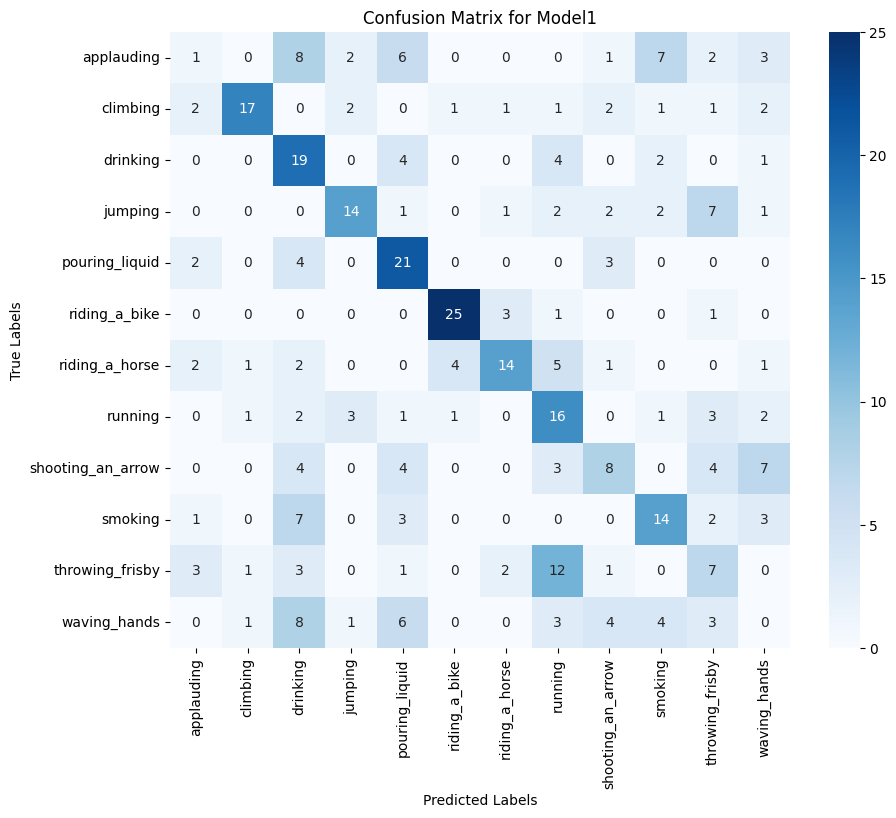

In [41]:
# 1. Get True Labels and Predictions
y_true = hmdb_test_data.classes
y_pred = model1.predict(hmdb_test_data)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

# 2. Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Get Class Labels (if available)
class_names = hmdb_test_data.class_indices  # Get class names from the generator

# 4. Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)  # Add labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Model1')
plt.show()

In [42]:
# Assuming y_true and y_pred are your true and predicted labels respectively
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.4315887327040382
Recall: 0.43333333333333335


# Train model2 on optical flow samples of the Hmdb51 dataset

## Model2 definition

In [45]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension.
    """
    super().__init__()
    self.seq = Sequential([
        # Spatial decomposition
        Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

In [46]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        LayerNormalization(),
        ReLU(),
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [47]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different
    sized filters and downsampled.
  """
  def __init__(self, units):
    super().__init__()
    self.seq = Sequential([
        Dense(units),
        LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [48]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters,
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [49]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height,
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [64]:
import einops
import tensorflow as tf

IMG_HEIGHT = 128
IMG_WIDTH = 128

input_shape = (None, 16, IMG_HEIGHT, IMG_WIDTH, 1)
input = Input(shape=(input_shape[1:]), name='input_2')
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = ResizeVideo(IMG_HEIGHT // 2, IMG_WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(IMG_HEIGHT // 4, IMG_WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(IMG_HEIGHT // 8, IMG_WIDTH // 8)(x)

# Block 3
x = Dropout(0.5)(x)
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(IMG_HEIGHT // 16, IMG_WIDTH // 16)(x)

# # Block 4
x = Dropout(0.5)(x)
x = ResizeVideo(IMG_HEIGHT // 32, IMG_WIDTH // 32)(x)
x = add_residual_block(x, 128, (3, 3, 3))

# Global Pooling
x = GlobalAveragePooling3D()(x)

# Reshape the output for temporal attention
# Shape before: (batch_size, 16, channels) where channels = the result of GlobalAveragePooling
x = Reshape((16, -1))(x)  # We keep the temporal dimension 16 and flatten spatial dimensions.

# Multi-Head Attention layer for temporal relationships
attention_output = MultiHeadAttention(num_heads=4, key_dim=64, dropout = 0.5)(x, x)

# # Add & Norm (optional but recommended for stability)
attention_output = LayerNormalization()(attention_output + x)

# # Continue with flattening, fully connected, and classification
x = GlobalAveragePooling1D()(attention_output)  # Pool over the time axis

x = Flatten()(x)
x = Dense(12, activation='softmax')(x)

model2 = keras.Model(input, x)

In [65]:
model2.summary()
model2.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_2 (InputLayer)      │ (None, 16, 128, 128,   │              0 │ -                      │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_plus1d_9            │ (None, 16, 128, 128,   │          1,584 │ input_2[0][0]          │
│ (Conv2Plus1D)             │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 128, 128,   │             64 │ conv2_plus1d_9[0][0]   │
│ (BatchNormalization)      │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_5 (ReLU)            │ (None, 16, 128, 128,   │              0 │ batch_normalization_2… │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_video_5            │ (None, 16, 64, 64, 16) │              0 │ re_lu_5[0][0]          │
│ (ResizeVideo)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_main_4           │ (None, 16, 64, 64, 16) │          6,272 │ resize_video_5[0][0]   │
│ (ResidualMain)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 16, 64, 64, 16) │              0 │ resize_video_5[0][0],  │
│                           │                        │                │ residual_main_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_video_6            │ (None, 16, 32, 32, 16) │              0 │ add_5[0][0]            │
│ (ResizeVideo)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ project_3 (Project)       │ (None, 16, 32, 32, 32) │            608 │ resize_video_6[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_main_5           │ (None, 16, 32, 32, 32) │         20,224 │ resize_video_6[0][0]   │
│ (ResidualMain)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 16, 32, 32, 32) │              0 │ project_3[0][0],       │
│                           │                        │                │ residual_main_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_video_7            │ (None, 16, 16, 16, 32) │              0 │ add_6[0][0]            │
│ (ResizeVideo)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 16, 16, 16, 32) │              0 │ resize_video_7[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ project_4 (Project)       │ (None, 16, 16, 16, 64) │          2,240 │ dropout_4[0][0]        │
├──────────────────────

 Total params: 449,556 (1.71 MB)

 Trainable params: 449,524 (1.71 MB)

 Non-trainable params: 32 (128.00 B)

## Model2 training

In [66]:
def get_callbacks( patience_lr):
    early_stop = EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=patience_lr, verbose=1, epsilon=1e-3, mode='min')
    return [early_stop, reduce_lr_loss]

In [67]:
X_train, X_val, y_train, y_val = train_test_split(optical_flow_train_data, optical_flow_train_labels,
                                                    stratify=optical_flow_train_labels,
                                                    test_size=0.25)
call_backs = get_callbacks(patience_lr=10)
history = model2.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), callbacks=call_backs)

Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.0912 - loss: 2.4822 - val_accuracy: 0.1095 - val_loss: 2.4809 - learning_rate: 5.0000e-04
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.1349 - loss: 2.4646 - val_accuracy: 0.1095 - val_loss: 2.4786 - learning_rate: 5.0000e-04
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.1771 - loss: 2.4513 - val_accuracy: 0.1429 - val_loss: 2.4665 - learning_rate: 5.0000e-04
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.1695 - loss: 2.4449 - val_accuracy: 0.1286 - val_loss: 2.4684 - learning_rate: 5.0000e-04
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.1584 - loss: 2.4527 - val_accuracy: 0.1476 - val_loss: 2.4600 - learning_rate: 5.0000e-04
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.1508 - loss: 2.4505 - val_accuracy: 0.1571 - val_loss: 2.4502 - learning_rate: 5.0000e-04
Epoch 7/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accur

In [68]:
model2.save("final_model_optical_flow.keras")

In [69]:
!cp final_model_optical_flow.keras /content/drive/MyDrive/Projects/Action_recognition

## Model evaluation on the test split

In [53]:
model2.load_weights("final_model_optical_flow.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 162 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 158 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [70]:
model2.evaluate(optical_flow_test_data, optical_flow_test_labels)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - accuracy: 0.1737 - loss: 2.4171


[2.411689281463623, 0.18611110746860504]

In [75]:
# 1. Get True Labels and Predictions
y_true = optical_flow_test_labels
y_pred = model2.predict(optical_flow_test_data)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

# 2. Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Get Class Labels (if available)
class_names = keep_stanford40  # Get class names from the generator

# 4. Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)  # Add labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Model1')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [76]:
# Assuming y_true and y_pred are your true and predicted labels respectively
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.15341862905902257
Recall: 0.18611111111111112


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Fusion of model1 and model2

## Load model weights

In [100]:
model1.load_weights("Hmdb51.keras")
model2.load_weights(f"final_model_optical_flow.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Fuse models

In [101]:
print(len(model1.layers), len(model2.layers))

21 29


In [102]:
# Concatenate the two input streams
merged = concatenate([model1.layers[17].output, model2.layers[27].output])

merged = BatchNormalization()(merged)
merged = Dropout(0.5)(merged)

# Add additional layers as needed
output = Dense(12, activation='softmax')(merged)

# Create the model
model3 = Model(inputs=[model1.input, model2.input], outputs=output)

# Print model summary
model3.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_2 (InputLayer)      │ (None, 16, 128, 128,   │              0 │ -                      │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_plus1d_9            │ (None, 16, 128, 128,   │          1,584 │ input_2[0][0]          │
│ (Conv2Plus1D)             │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 128, 128,   │             64 │ conv2_plus1d_9[0][0]   │
│ (BatchNormalization)      │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_5 (ReLU)            │ (None, 16, 128, 128,   │              0 │ batch_normalization_2… │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_video_5            │ (None, 16, 64, 64, 16) │              0 │ re_lu_5[0][0]          │
│ (ResizeVideo)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_main_4           │ (None, 16, 64, 64, 16) │          6,272 │ resize_video_5[0][0]   │
│ (ResidualMain)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 16, 64, 64, 16) │              0 │ resize_video_5[0][0],  │
│                           │                        │                │ residual_main_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_video_6            │ (None, 16, 32, 32, 16) │              0 │ add_5[0][0]            │
│ (ResizeVideo)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_1 (InputLayer)      │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ project_3 (Project)       │ (None, 16, 32, 32, 32) │            608 │ resize_video_6[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_main_5           │ (None, 16, 32, 32, 32) │         20,224 │ resize_video_6[0][0]   │
│ (ResidualMain)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 254, 254, 32)   │            320 │ input_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 16, 32, 32, 32) │              0 │ project_3[0][0],       │
│                           │                        │                │ residual_main_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 252, 252, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_video_7       

 Total params: 1,176,660 (4.49 MB)

 Trainable params: 14,460 (56.48 KB)

 Non-trainable params: 1,162,200 (4.43 MB)

In [103]:
model3.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [104]:
print( len( model3.layers))

50


In [105]:
for i in range( len( model3.layers)):
  model3.layers[i].trainable = True
for i in range( len( model3.layers) - 3):
  model3.layers[i].trainable = False

## Model3 training

In [85]:
!mkdir final_checkpoints

In [86]:
k = 5
folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(optical_flow_train_data, optical_flow_train_labels))

In [87]:
def get_callbacks(name_weights, patience_lr):
    mcp_save = ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, epsilon=1e-4, mode='min')
    return [mcp_save, reduce_lr_loss]

In [106]:
batch_size = 32

for j, (train_idx, val_idx) in enumerate(folds):

    print('\nFold ',j)
    X_train_optic = optical_flow_train_data[train_idx]
    y_train_optic = optical_flow_train_labels[train_idx]
    X_valid_optic = optical_flow_train_data[val_idx]
    y_valid_optic = optical_flow_train_labels[val_idx]
    X_train_frame = hmdb_train_data[train_idx]
    y_train_frame = hmdb_train_data[train_idx]
    X_valid_frame = hmdb_train_data[val_idx]
    y_valid_frame = hmdb_train_data[val_idx]

    name_weights = f"final_checkpoints/final_model_fold_{j}_weights.keras"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    generator = get_data_generator(X_train_frame, X_train_optic, y_train_optic, batch_size = batch_size)
    model3.fit(
                generator,
                steps_per_epoch = len(X_train_optic) // batch_size,
                batch_size = batch_size,
                epochs=30,
                shuffle=True,
                verbose=1,
                validation_data = ({"input_1": X_valid_frame, "input_2": X_valid_optic}, y_valid_optic),
                callbacks = callbacks)


Fold  0
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 538ms/step - accuracy: 0.0929 - loss: 2.4924 - val_accuracy: 0.1667 - val_loss: 2.4811 - learning_rate: 5.0000e-04
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.1717 - loss: 2.4526 - val_accuracy: 0.2440 - val_loss: 2.4707 - learning_rate: 5.0000e-04
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.2469 - loss: 2.3778 - val_accuracy: 0.2976 - val_loss: 2.4570 - learning_rate: 5.0000e-04
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.2933 - loss: 2.3552 - val_accuracy: 0.3452 - val_loss: 2.4397 - learning_rate: 5.0000e-04
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.3532 - loss: 2.3058 - val_accuracy: 0.4107 - val_loss: 2.4242 - learning_rate: 5.0000e-04
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.3682 - loss: 2.2721 - val_accuracy: 0.4583 - val_loss: 2.4097 - learning_rate: 5.0000e-04
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accura

In [112]:
model3.save("final_model.keras")

In [113]:
!cp final_model.keras /content/drive/MyDrive/Projects/Action_recognition

## Model evaluation on the test split

In [107]:
max_accuracy = 0
best_fold = 0

for i in range(k):
  model3.load_weights(f"final_checkpoints/final_model_fold_{str(i)}_weights.keras")
  loss, accuracy = model3.evaluate(
          {
              "input_2": optical_flow_test_data,
              "input_1": hmdb_test_data
          },
          hmdb_test_labels
  )
  print(f"{i} - {accuracy}")
  if accuracy > max_accuracy:
    max_accuracy = accuracy
    best_fold = i

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4882 - loss: 2.1716
0 - 0.43888887763023376
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4894 - loss: 2.1381
1 - 0.43888887763023376
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4794 - loss: 2.1402
2 - 0.4305555522441864
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5080 - loss: 2.1286
3 - 0.4472222328186035
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4962 - loss: 2.1273
4 - 0.4444444477558136


In [108]:
model3.load_weights(f"final_checkpoints/final_model_fold_{best_fold}_weights.keras")

In [110]:
# 1. Get True Labels and Predictions
y_true = optical_flow_test_labels
y_pred = model3.predict({
              "input_2": optical_flow_test_data,
              "input_1": hmdb_test_data
          })
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

# 2. Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Get Class Labels (if available)
class_names = keep_stanford40  # Get class names from the generator

# 4. Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)  # Add labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Model1')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 395ms/step


In [111]:
# Assuming y_true and y_pred are your true and predicted labels respectively
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.44300537381723876
Recall: 0.44722222222222224
